<a href="https://colab.research.google.com/github/aydanazar/garbage_classification/blob/main/Classification_ResNet_Perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import and Pre-Process Dataset

In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D

from sklearn.cluster import KMeans
from scipy.cluster.vq import kmeans
from skimage.feature import hog
from skimage import exposure
from sklearn.decomposition import PCA
from scipy.cluster.vq import vq
import glob
from joblib import dump, load
from sklearn.manifold import TSNE
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Download Dataset from Kaggle
Steps to Download Kaggle datasets in Google Colab:
https://www.kaggle.com/discussions/general/156610

In [5]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aydanazar","key":"06b65fc2d3d7e1b580cebbc71ffeed76"}'}

In [6]:
# check for kaggle.json file
!ls -lha kaggle.json

-rw-r--r-- 1 root root 65 Dec 16 01:07 kaggle.json


In [7]:
# install kaggle API client
!pip install -q kaggle

# move it under a new kaggle directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# set permissions
!chmod 600 /root/.kaggle/kaggle.json

# check current directory (should be '/content')
!pwd

/content


In [8]:
# list kaggle datasets
!kaggle datasets list

ref                                                                 title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
thedrcat/daigt-v2-train-dataset                                     DAIGT V2 Train Dataset                            29MB  2023-11-16 01:38:36           1928        190  1.0              
muhammadbinimran/housing-price-prediction-data                      Housing Price Prediction Data                    763KB  2023-11-21 17:56:32           8585        151  1.0              
thedevastator/books-sales-and-ratings                               Books Sales and Ratings                           53KB  2023-12-06 04:54:33           2006         29  1.0              
thedrcat/daigt-proper-train-dataset                    

In [9]:
# download garbage classification dataset
!kaggle datasets download -d mostafaabla/garbage-classification

 97% 233M/239M [00:02<00:00, 121MB/s]
100% 239M/239M [00:02<00:00, 123MB/s]


In [10]:
# unzip dataset to colab directory
!unzip garbage-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: garbage_classification/paper/paper381.jpg  
  inflating: garbage_classification/paper/paper382.jpg  
  inflating: garbage_classification/paper/paper383.jpg  
  inflating: garbage_classification/paper/paper384.jpg  
  inflating: garbage_classification/paper/paper385.jpg  
  inflating: garbage_classification/paper/paper386.jpg  
  inflating: garbage_classification/paper/paper387.jpg  
  inflating: garbage_classification/paper/paper388.jpg  
  inflating: garbage_classification/paper/paper389.jpg  
  inflating: garbage_classification/paper/paper39.jpg  
  inflating: garbage_classification/paper/paper390.jpg  
  inflating: garbage_classification/paper/paper391.jpg  
  inflating: garbage_classification/paper/paper392.jpg  
  inflating: garbage_classification/paper/paper393.jpg  
  inflating: garbage_classification/paper/paper394.jpg  
  inflating: garbage_classification/paper/paper395.jpg  
  inflating: garbage_classification/pa

### Process Dataset as dataframe

In [11]:
# Path to garbase dataset
path = '/content/garbage_classification'

# Preparing lists to store images and respective labels
images= []
labels = []

# loop through directories and save images and labels to lists
for dirs in os.listdir(path):
  img_paths = glob.glob(path + '/' + dirs + '/*.jpg')
  for img in img_paths:
    labels.append(dirs)
    images.append(cv2.imread(img))

# convert to pandas dataframe
data_dict = {"image" : images, "class" : labels}
data_df = pd.DataFrame.from_dict(data_dict)
data_df.head()

,image,class
0,"[[[224, 215, 211], [226, 215, 211], [233, 212,...",metal
1,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",metal
2,"[[[142, 155, 171], [142, 155, 171], [141, 154,...",metal
3,"[[[218, 221, 226], [218, 221, 226], [218, 221,...",metal
4,"[[[159, 175, 192], [159, 175, 192], [160, 176,...",metal


In [ ]:
# get count of images in each class
data_df['class'].value_counts()

clothes        5325
shoes          1977
paper          1050
biological      985
battery         945
cardboard       891
plastic         865
white-glass     775
metal           769
trash           697
green-glass     629
brown-glass     607
Name: class, dtype: int64

In [ ]:
## Manage class imbalance: sample 1000 images from clothes and shoes
clothes_mask = data_df['class'] == 'clothes'
shoes_mask = data_df['class'] == 'shoes'

clothes_sampled = data_df[clothes_mask].sample(1000, random_state=42).reset_index(drop=True)
shoes_sampled = data_df[shoes_mask].sample(1000, random_state=42).reset_index(drop=True)

In [ ]:
data_df_archive = data_df # save if needed for future reference

# Get data without clothes or shoes
data_df_masked = data_df[(~clothes_mask) & (~shoes_mask)]

# Concatenate data without clothes or shoes with the 1000 randomly sampled clothes and shoes
data_df = pd.concat([data_df_masked, clothes_sampled, shoes_sampled])

# confirm 1000 records for clothes and shoes
data_df['class'].value_counts()

paper          1050
clothes        1000
shoes          1000
biological      985
battery         945
cardboard       891
plastic         865
white-glass     775
metal           769
trash           697
green-glass     629
brown-glass     607
Name: class, dtype: int64

In [ ]:
# Saving balanceed data to csv
data_df['class'].to_csv('labels.csv', index=False)

## Feature Extraction

### ResNet Feature Extraction

In [ ]:
from keras.utils import img_to_array, array_to_img

# Prepare list for feature extraction from ResNet
resnet_features = []

# Use ResNet50 with pretrained weights from imagenet
base_model = ResNet50(weights='imagenet')

# Prepare the ResNet model, where the model output will be the GlobalAveragePooling layer rather than the final dense layer
model = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)

images = np.array(data_df["image"])
labels = np.array(data_df["class"])

# Prepare image target size for resizing
target_size = (224, 224)

for img in images:

  img = array_to_img(img)
  img = img.resize(target_size)
  img = img_to_array(img)

  # Preprocess the img to appropriate ResNet50 format
  img = preprocess_input(img)

  # Creates another dimension that signifies the batch size to 1
  img = np.expand_dims(img, axis=0)
  resnet_feature = model.predict(img)
  resnet_features.append(resnet_feature.flatten())

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 70ms/step


In [ ]:
# Save the features into a numpy array for later use
resnet = np.array(resnet_features)
np.save("/content/drive/MyDrive/W281/Processed_Dataset_Feature_Vector_CSVs/imgs_resnet.npy", resnet)

### Load feature vectors from csv's

In [3]:
path = '/content/drive/MyDrive/W281/Processed_Dataset_Feature_Vector_CSVs/'

# Load in labels
data_df = pd.read_csv(path + 'labels.csv')

# Load in ResNet features and add as column to labels
resnet_features = np.load(path + 'imgs_resnet.npy')
data_df['resnet'] = list(resnet_features)

# Load in HOG_PCA features and add as column to labels
hog_pca = np.loadtxt(path + 'imgs_hog_pca450.csv', delimiter=',')
data_df['hog_pca'] = list(hog_pca)

# Load in BOVW and add as column to labels
visual_words = np.load(path + 'imgs_bovw_n20_k250.npy')
data_df['bovw'] = list(visual_words)

# Load in BOVC and add as column to labels
color_file = np.load(path + 'imgs_bovc.npy')
data_df['bovc'] = list(color_file)

In [4]:
data_df.head()

,class,resnet,hog_pca,bovw,bovc
0,battery,"[0.0, 0.3818555, 0.0, 0.06290764, 0.08147252, ...","[2.189156354441641, 0.7400468735375466, -0.663...","[[11.017208099365234, 5.51816463470459, 5.8986...","[[111, 116, 120], [13, 14, 16], [252, 252, 252]]"
1,battery,"[0.43193766, 0.38143426, 0.35062382, 0.0059453...","[-0.6218759585863919, -0.2459165625116312, 0.0...","[[11.646025657653809, 6.187615394592285, 6.089...","[[228, 229, 229], [75, 145, 61], [75, 145, 61]]"
2,battery,"[0.100634456, 1.5973613, 0.06269982, 0.0, 0.0,...","[-0.27365468556605543, 0.6007934622690123, 0.0...","[[13.888777732849121, 140.70640563964844, 66.3...","[[252, 252, 252], [111, 116, 120], [53, 52, 52]]"
3,battery,"[0.08150741, 0.38641408, 0.0, 0.0, 0.007759203...","[0.29577646577267, -0.16461600332483664, -0.06...","[[24.290037155151367, 17.709962844848633, 9.96...","[[41, 40, 40], [228, 229, 229], [140, 144, 146]]"
4,battery,"[1.3157188, 1.047845, 0.14115347, 0.019219099,...","[0.2014304849449809, 0.2116504775821551, -0.01...","[[4.386398792266846, 13.843894958496094, 58.67...","[[252, 252, 252], [39, 35, 138], [131, 99, 193]]"


### t-SNE Visualization

In [5]:
def tsne_viz(df, feature_vector, perplexity, learning_rate, max_iter):

  ### Set up tSNE and fit to feature vector
  tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, n_iter=max_iter)
  tsne_results = tsne.fit_transform(feature_vector)


  ## plotting t-SNE chart
  data_tSNE = df
  data_tSNE["t-SNE-1"] = tsne_results[:,0]
  data_tSNE["tSNE-2"] = tsne_results[:,1]

  plt.figure(figsize=(10,8))
  sns.scatterplot(
      x="t-SNE-1", y="tSNE-2",
      hue="class",
      palette=sns.color_palette("hls", 12),
      data=data_tSNE,
      legend="full",
      alpha=0.3
  )
  plt.show()

<ipython-input-5-8402dc3a9c1c>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_tSNE["t-SNE-1"] = tsne_results[:,0]
<ipython-input-5-8402dc3a9c1c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_tSNE["tSNE-2"] = tsne_results[:,1]


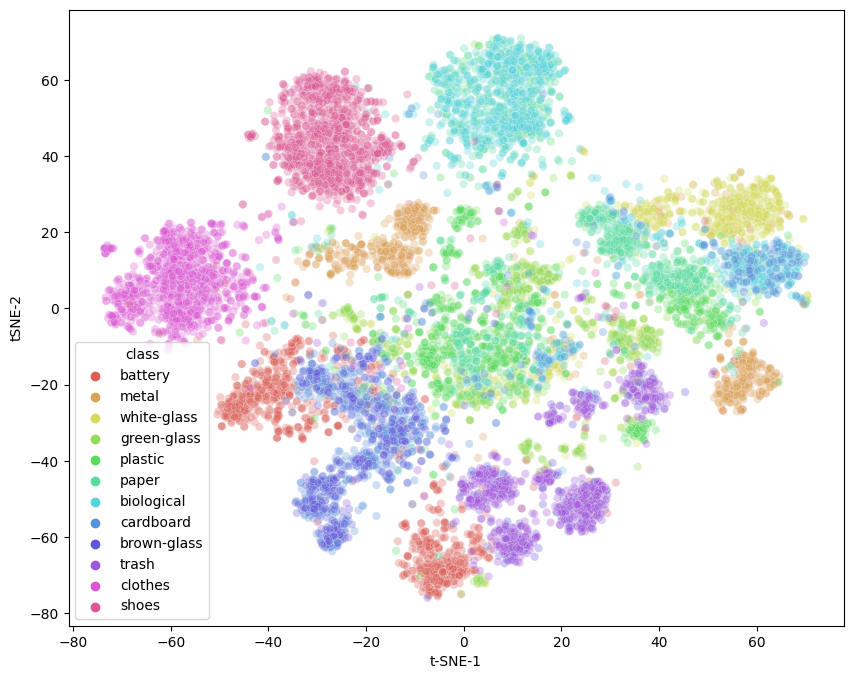

In [8]:
### T-SNE on ResNet feature vector
resnet_vector = np.array([list(x) for x in data_df['resnet']])
tsne_viz(data_df[['class', 'resnet']], resnet_vector, 50, 300, 1000)

### Split into Train, Test, Val

In [ ]:
# split into train, validation, and test (70%, 10%, 20%)
train, val, test = np.split(data_df.sample(frac=1, random_state=42),
                       [int(.7*len(data_df)), int(.8*len(data_df))])

print("Number of Images:")
print("Train:", len(train))
print("Validation:", len(val))
print("Test:", len(test))

Number of Images:
Train: 7149
Validation: 1021
Test: 2043


In [ ]:
train.groupby('class').size()

class
battery        678
biological     682
brown-glass    413
cardboard      614
clothes        703
green-glass    445
metal          546
paper          753
plastic        618
shoes          680
trash          480
white-glass    537
dtype: int64

In [ ]:
val.groupby('class').size()

class
battery         83
biological     104
brown-glass     52
cardboard       98
clothes        102
green-glass     56
metal           66
paper           92
plastic         79
shoes          116
trash           77
white-glass     96
dtype: int64

In [ ]:
test.groupby('class').size()

class
battery        184
biological     199
brown-glass    142
cardboard      179
clothes        195
green-glass    128
metal          157
paper          205
plastic        168
shoes          204
trash          140
white-glass    142
dtype: int64

## Classification

In [ ]:
# Create labels for train, val, and test sets
y_train = np.array(train['class'])
y_val = np.array(val['class'])
y_test = np.array(test['class'])

### Perceptron using ResNet and HOG PCA

In [ ]:
def list_feature(df, feature):
  """
    Extract and convert features from a dataframe column into a numpy array of lists.

    Example:
    >>> df = pd.DataFrame({'hog_pca': [[1,2,3], [4,5,6]],
                           'resnet': [[7,8,9], [10,11,12]]})
    >>> list_feature(df, 'hog_pca')
    array([[1, 2, 3],
           [4, 5, 6]])
  """
  return np.array([list(x) for x in df[feature]])

X_train_combined = np.concatenate([list_feature(train, 'hog_pca'), list_feature(train, 'resnet')], axis=1)
X_val_combined = np.concatenate([list_feature(val, 'hog_pca'), list_feature(val, 'resnet')], axis=1)
X_test_combined = np.concatenate([list_feature(test, 'hog_pca'), list_feature(test, 'resnet')], axis=1)


In [ ]:
from sklearn.neural_network import MLPClassifier

# Simple Perceptron with one hidden layer of 100 nodes and 1000 epochs
perceptron = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000)
perceptron.fit(X_train_combined, y_train)
print("Simple Perceptron Classifier:")
print(classification_report(y_val, perceptron.predict(X_val_combined)))

# Evaluate on the test set
print("Evaluation on Test Set:")
print("Simple Perceptron:")
print(classification_report(y_test, perceptron.predict(X_test_combined)))

Simple Perceptron Classifier:
              precision    recall  f1-score   support

     battery       0.90      0.90      0.90        83
  biological       0.68      0.70      0.69       104
 brown-glass       0.58      0.48      0.53        52
   cardboard       0.69      0.69      0.69        98
     clothes       0.99      1.00      1.00       102
 green-glass       0.48      0.52      0.50        56
       metal       0.86      0.77      0.82        66
       paper       0.64      0.67      0.66        92
     plastic       0.71      0.70      0.71        79
       shoes       0.98      0.96      0.97       116
       trash       0.79      0.82      0.80        77
 white-glass       0.72      0.74      0.73        96

    accuracy                           0.77      1021
   macro avg       0.75      0.75      0.75      1021
weighted avg       0.77      0.77      0.77      1021

Evaluation on Test Set:
Simple Perceptron:
              precision    recall  f1-score   support

     

In [ ]:
model = load("/content/drive/MyDrive/W281/Processed_Dataset_Feature_Vector_CSVs/best_perceptron.joblib")
model

MLPClassifier(activation='tanh', max_iter=1000)

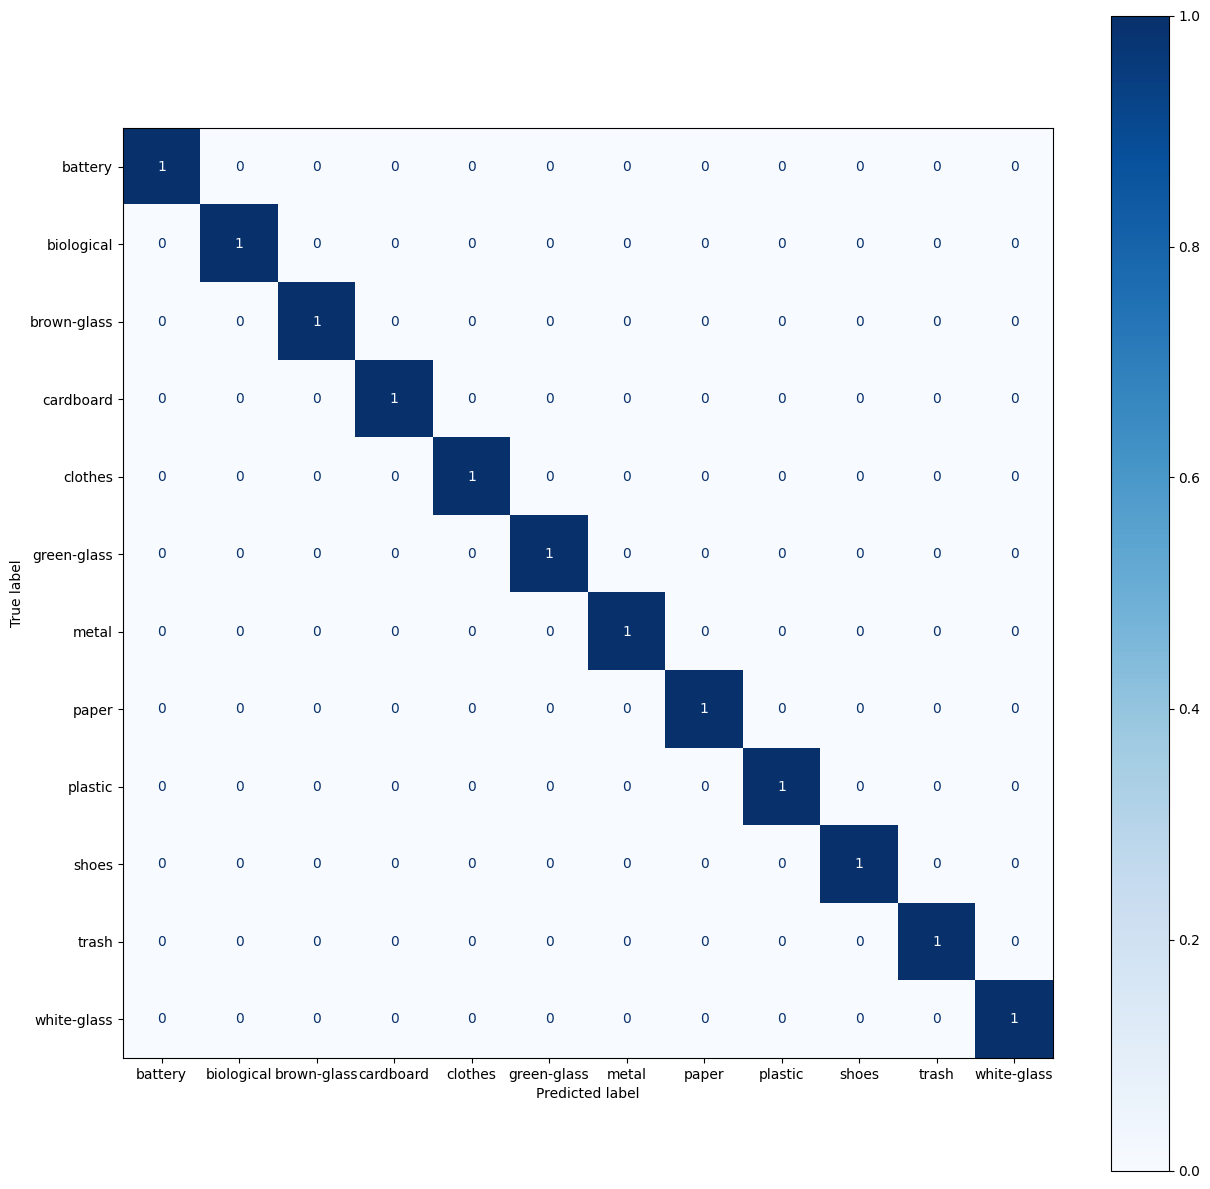

In [ ]:
# normalized confusion matrix on train
y_train_pred = model.predict(X_train_combined)
fig, ax = plt.subplots(figsize=(15,15))
cmp = ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, cmap='Blues', normalize='true', ax=ax)
plt.savefig('confusion_2.png')

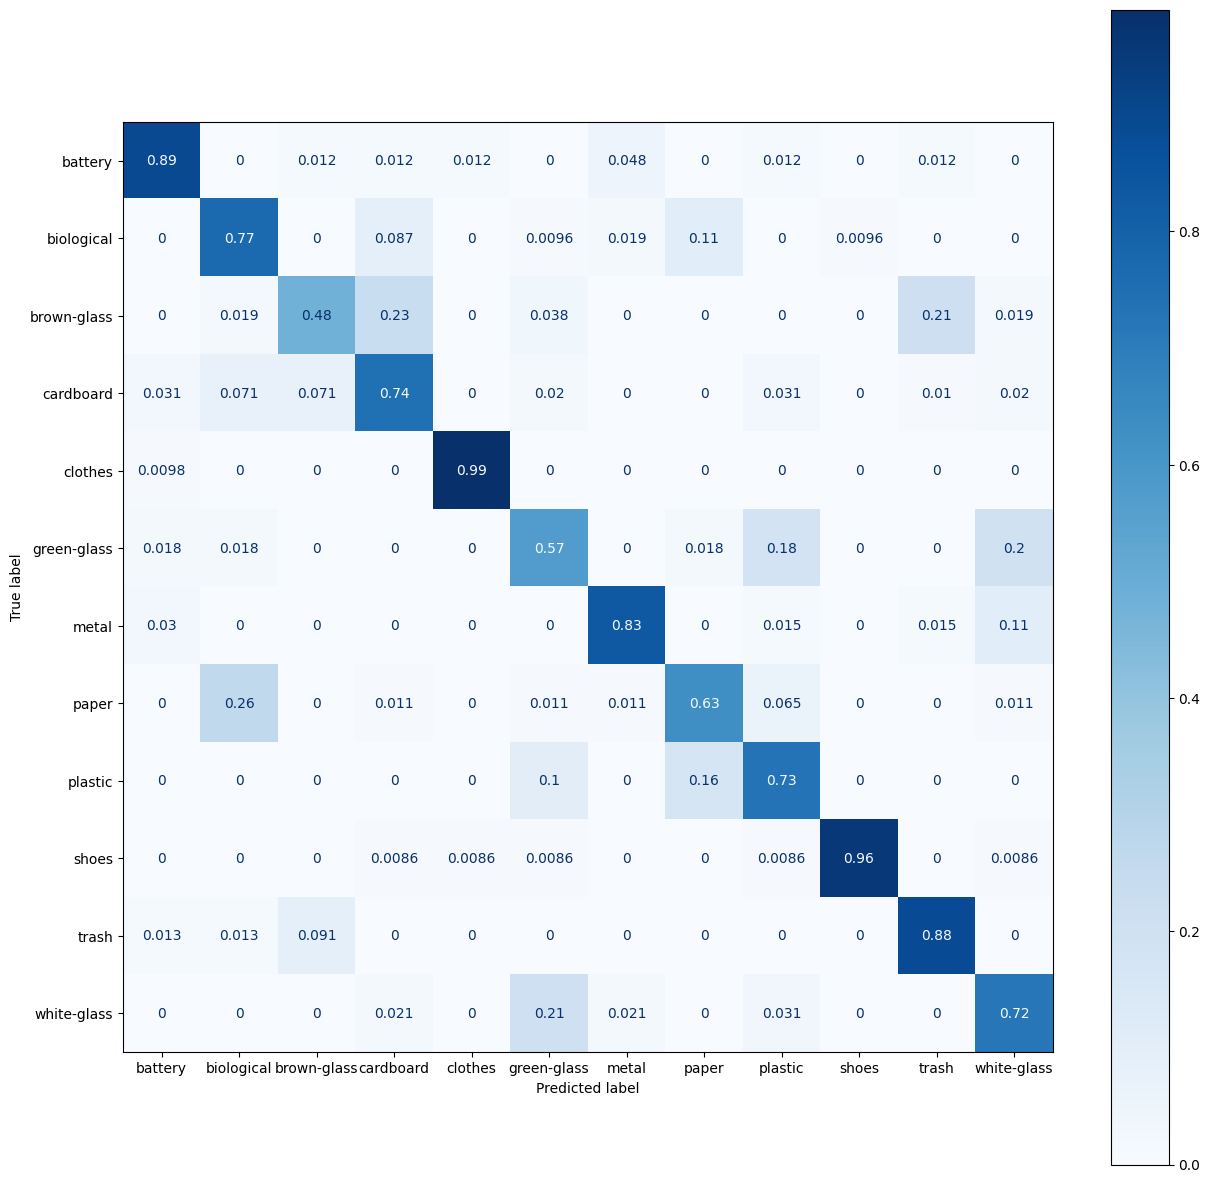

In [ ]:
# normalized confusion matrix on train
y_val_pred = model.predict(X_val_combined)
fig, ax = plt.subplots(figsize=(15,15))
cmp = ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred, cmap='Blues', normalize='true', ax=ax)
plt.savefig('confusion_val_2.png')

In [ ]:
y_pred = model.predict(X_val_combined)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_val, model.predict(X_val_combined)))

Accuracy: 0.7874632713026445

Classification Report:

              precision    recall  f1-score   support

     battery       0.90      0.89      0.90        83
  biological       0.70      0.77      0.73       104
 brown-glass       0.62      0.48      0.54        52
   cardboard       0.74      0.74      0.74        98
     clothes       0.98      0.99      0.99       102
 green-glass       0.48      0.57      0.52        56
       metal       0.86      0.83      0.85        66
       paper       0.70      0.63      0.66        92
     plastic       0.70      0.73      0.72        79
       shoes       0.99      0.96      0.97       116
       trash       0.83      0.88      0.86        77
 white-glass       0.75      0.72      0.73        96

    accuracy                           0.79      1021
   macro avg       0.77      0.77      0.77      1021
weighted avg       0.79      0.79      0.79      1021



In [ ]:
y_pred = model.predict(X_test_combined)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, model.predict(X_test_combined)))

Accuracy: 0.7645619187469408

Classification Report:

              precision    recall  f1-score   support

     battery       0.92      0.89      0.90       184
  biological       0.68      0.73      0.70       199
 brown-glass       0.61      0.35      0.45       142
   cardboard       0.63      0.73      0.68       179
     clothes       0.96      0.99      0.98       195
 green-glass       0.64      0.48      0.54       128
       metal       0.86      0.75      0.80       157
       paper       0.71      0.63      0.67       205
     plastic       0.67      0.82      0.74       168
       shoes       0.96      0.96      0.96       204
       trash       0.78      0.90      0.84       140
 white-glass       0.64      0.79      0.70       142

    accuracy                           0.76      2043
   macro avg       0.75      0.75      0.75      2043
weighted avg       0.76      0.76      0.76      2043



### Perceptron using ResNet, HOG PCA, and BOVC

In [ ]:
def list_feature(df, feature):
  return np.array([list(x) for x in df[feature]])

def flatten_feature(df, feature):
  return np.array([x.flatten() for x in df[feature]])

X_train_combined = np.concatenate([list_feature(train, 'hog_pca'), list_feature(train, 'resnet'), flatten_feature(train, 'bovc')], axis=1)
X_val_combined = np.concatenate([list_feature(val, 'hog_pca'), list_feature(val, 'resnet'), flatten_feature(val, 'bovc')], axis=1)
X_test_combined = np.concatenate([list_feature(test, 'hog_pca'), list_feature(test, 'resnet'), flatten_feature(test, 'bovc')], axis=1)


In [ ]:
from sklearn.neural_network import MLPClassifier

# Simple Perceptron with tahn activation and trained on 1000 epochs
perceptron = MLPClassifier(activation='tanh', max_iter=1000)
perceptron.fit(X_train_combined, y_train)
print("Simple Perceptron Classifier:")
print(classification_report(y_val, perceptron.predict(X_val_combined)))

# Evaluate on the test set
print("Evaluation on Test Set:")
print("Simple Perceptron:")
print(classification_report(y_test, perceptron.predict(X_test_combined)))

Simple Perceptron Classifier:
              precision    recall  f1-score   support

     battery       0.96      0.92      0.94        83
  biological       0.76      0.81      0.79       104
 brown-glass       0.70      0.58      0.63        52
   cardboard       0.75      0.81      0.77        98
     clothes       0.98      0.99      0.99       102
 green-glass       0.83      0.86      0.84        56
       metal       0.87      0.82      0.84        66
       paper       0.70      0.75      0.72        92
     plastic       0.81      0.81      0.81        79
       shoes       1.00      0.97      0.99       116
       trash       0.88      0.90      0.89        77
 white-glass       0.88      0.83      0.86        96

    accuracy                           0.85      1021
   macro avg       0.84      0.84      0.84      1021
weighted avg       0.85      0.85      0.85      1021

Evaluation on Test Set:
Simple Perceptron:
              precision    recall  f1-score   support

     

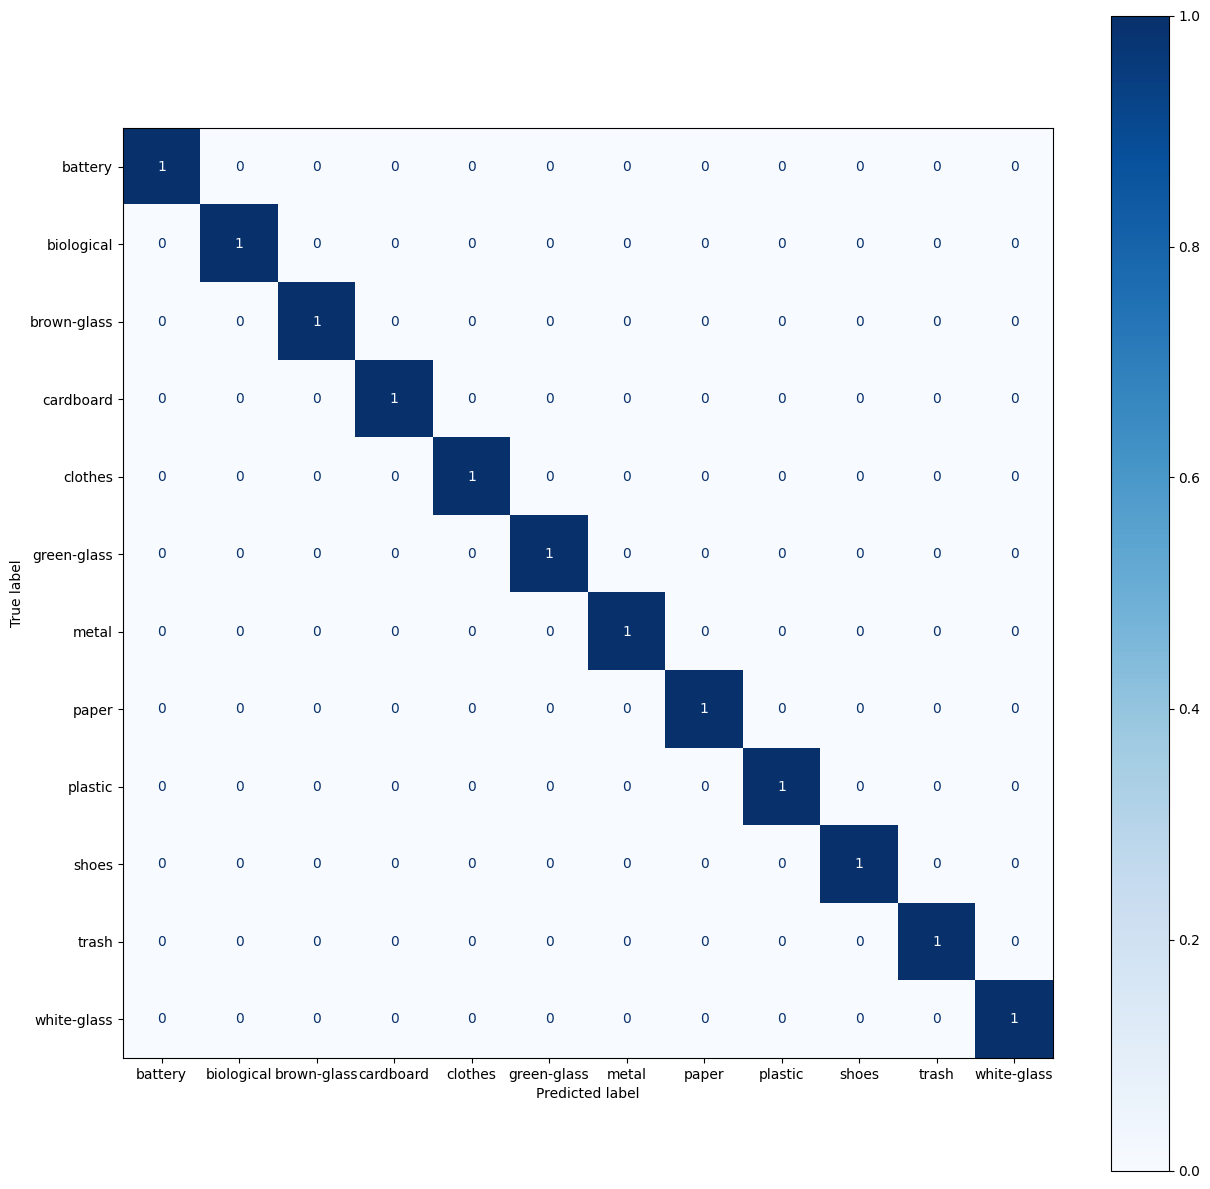

In [ ]:
# normalized confusion matrix on train
y_train_pred = perceptron.predict(X_train_combined)
fig, ax = plt.subplots(figsize=(15,15))
cmp = ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, cmap='Blues', normalize='true', ax=ax)
plt.savefig('confusion.png')

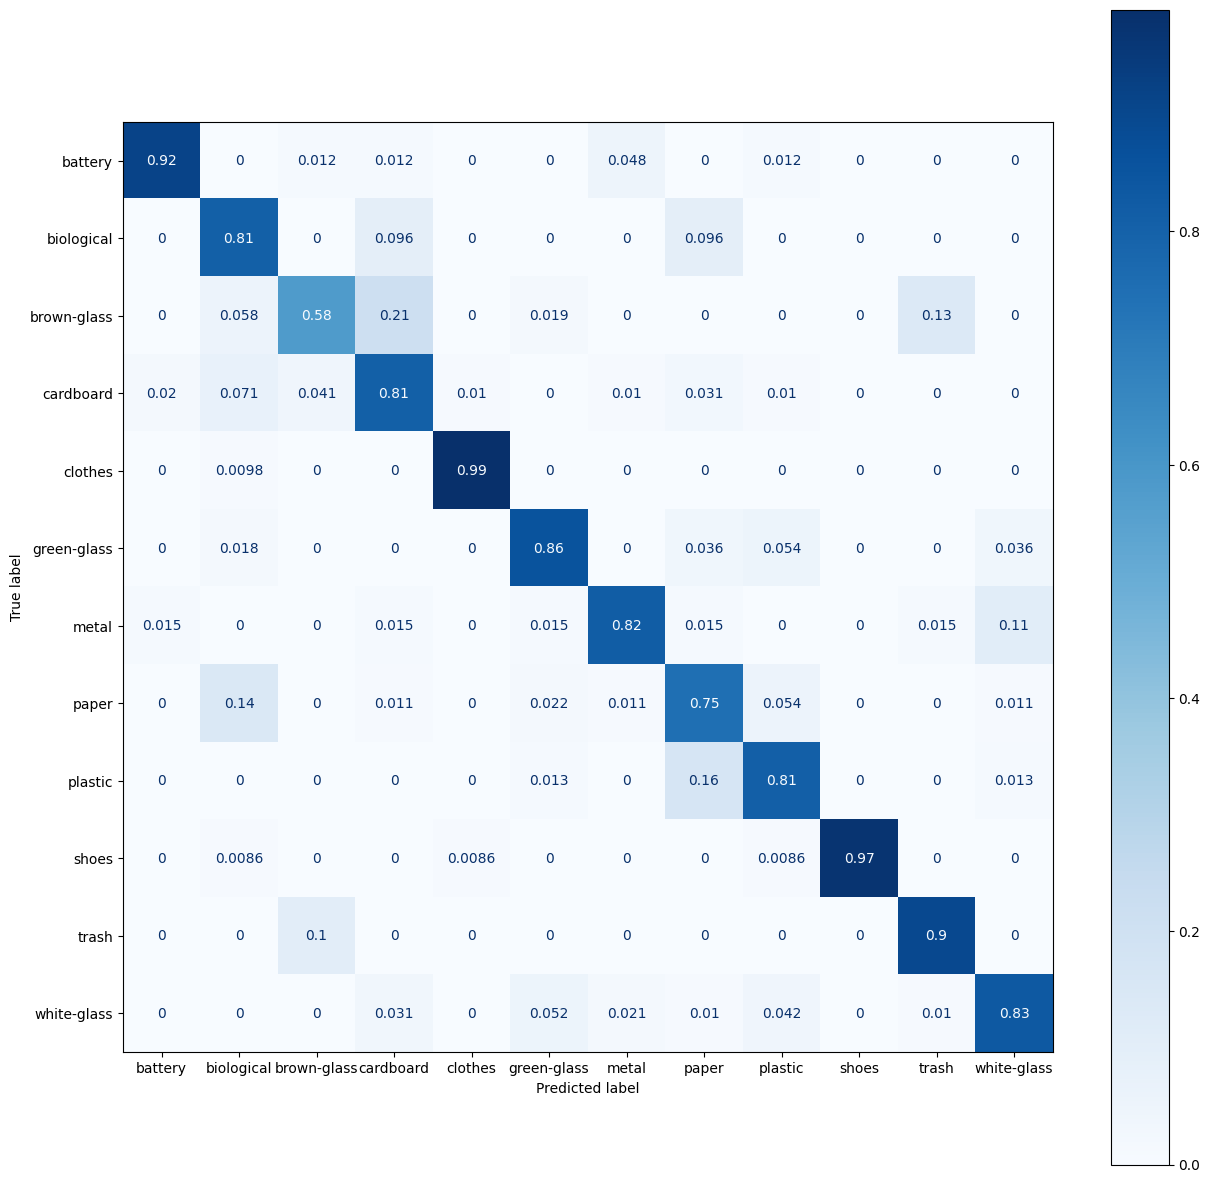

In [ ]:
# normalized confusion matrix on train
y_val_pred = perceptron.predict(X_val_combined)
fig, ax = plt.subplots(figsize=(15,15))
cmp = ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred, cmap='Blues', normalize='true', ax=ax)
plt.savefig('confusion_val.png')

In [ ]:
y_pred = perceptron.predict(X_val_combined)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_val, perceptron.predict(X_val_combined)))

Accuracy: 0.8491674828599413

Classification Report:

              precision    recall  f1-score   support

     battery       0.96      0.92      0.94        83
  biological       0.76      0.81      0.79       104
 brown-glass       0.70      0.58      0.63        52
   cardboard       0.75      0.81      0.77        98
     clothes       0.98      0.99      0.99       102
 green-glass       0.83      0.86      0.84        56
       metal       0.87      0.82      0.84        66
       paper       0.70      0.75      0.72        92
     plastic       0.81      0.81      0.81        79
       shoes       1.00      0.97      0.99       116
       trash       0.88      0.90      0.89        77
 white-glass       0.88      0.83      0.86        96

    accuracy                           0.85      1021
   macro avg       0.84      0.84      0.84      1021
weighted avg       0.85      0.85      0.85      1021



In [ ]:
y_pred = perceptron.predict(X_test_combined)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, perceptron.predict(X_test_combined)))

Accuracy: 0.846793930494371

Classification Report:

              precision    recall  f1-score   support

     battery       0.96      0.89      0.92       184
  biological       0.80      0.78      0.79       199
 brown-glass       0.76      0.63      0.69       142
   cardboard       0.74      0.81      0.77       179
     clothes       0.97      0.99      0.98       195
 green-glass       0.89      0.84      0.86       128
       metal       0.87      0.78      0.82       157
       paper       0.80      0.80      0.80       205
     plastic       0.79      0.85      0.82       168
       shoes       0.94      0.96      0.95       204
       trash       0.87      0.89      0.88       140
 white-glass       0.76      0.89      0.82       142

    accuracy                           0.85      2043
   macro avg       0.85      0.84      0.84      2043
weighted avg       0.85      0.85      0.85      2043



### Hyperparameter Search

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### HOG PCA + ResNet

In [ ]:
# The parameters and search space for hyperparameter tuning
param_grid = {'hidden_layer_sizes': [(100,), (100,100), (200,100), (200, 100, 100)],
              'learning_rate_init': [0.0001, 0.001, 0.01],
              'activation': ['identity', 'tanh', 'relu']}

# Utilizing gridsearch for hyperparameter tuning with 5-fold CV
grid_search = GridSearchCV(MLPClassifier(max_iter=1000), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_combined, y_train)
best_mlp = grid_search.best_estimator_
print(classification_report(y_test, best_mlp.predict(X_test_combined)))

              precision    recall  f1-score   support

     battery       0.92      0.89      0.90       184
  biological       0.68      0.73      0.70       199
 brown-glass       0.61      0.35      0.45       142
   cardboard       0.63      0.73      0.68       179
     clothes       0.96      0.99      0.98       195
 green-glass       0.64      0.48      0.54       128
       metal       0.86      0.75      0.80       157
       paper       0.71      0.63      0.67       205
     plastic       0.67      0.82      0.74       168
       shoes       0.96      0.96      0.96       204
       trash       0.78      0.90      0.84       140
 white-glass       0.64      0.79      0.70       142

    accuracy                           0.76      2043
   macro avg       0.75      0.75      0.75      2043
weighted avg       0.76      0.76      0.76      2043



### HOG PCA + BOVC + ResNet

In [ ]:
param_grid = {'hidden_layer_sizes': [(100,), (100,100), (200,100), (200, 100, 100)],
              'learning_rate_init': [0.0001, 0.001, 0.01],
              'activation': ['identity', 'tanh', 'relu']}
grid_search = GridSearchCV(MLPClassifier(max_iter=1000), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_combined, y_train)
best_mlp = grid_search.best_estimator_
print(classification_report(y_test, best_mlp.predict(X_test_combined)))

              precision    recall  f1-score   support

     battery       0.93      0.90      0.91       184
  biological       0.79      0.81      0.80       199
 brown-glass       0.77      0.71      0.74       142
   cardboard       0.77      0.78      0.77       179
     clothes       0.96      0.99      0.98       195
 green-glass       0.88      0.88      0.88       128
       metal       0.83      0.75      0.79       157
       paper       0.82      0.75      0.78       205
     plastic       0.81      0.85      0.83       168
       shoes       0.96      0.96      0.96       204
       trash       0.92      0.89      0.91       140
 white-glass       0.75      0.89      0.82       142

    accuracy                           0.85      2043
   macro avg       0.85      0.85      0.85      2043
weighted avg       0.85      0.85      0.85      2043



In [ ]:
best_mlp

MLPClassifier(activation='tanh', hidden_layer_sizes=(200, 100),
              learning_rate_init=0.0001, max_iter=1000)

In [ ]:
perceptron

MLPClassifier(activation='tanh', max_iter=1000)

In [ ]:
# Save models
dump(best_mlp, '/content/drive/MyDrive/W281/Processed_Dataset_Feature_Vector_CSVs/best_perceptron_3f.joblib')
dump(perceptron, '/content/drive/MyDrive/W281/Processed_Dataset_Feature_Vector_CSVs/og_perceptron_3f.joblib')

['/content/drive/MyDrive/W281/Processed_Dataset_Feature_Vector_CSVs/og_perceptron_3f.joblib']

In [ ]:
# Load models
best_mlp = load('/content/drive/MyDrive/W281/Processed_Dataset_Feature_Vector_CSVs/best_perceptron_3f.joblib')
perceptron = load('/content/drive/MyDrive/W281/Processed_Dataset_Feature_Vector_CSVs/og_perceptron_3f.joblib')

In [ ]:
y_pred = best_mlp.predict(X_test_combined)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, best_mlp.predict(X_test_combined)))

Accuracy: 0.8497307880567793

Classification Report:

              precision    recall  f1-score   support

     battery       0.93      0.90      0.91       184
  biological       0.79      0.81      0.80       199
 brown-glass       0.77      0.71      0.74       142
   cardboard       0.77      0.78      0.77       179
     clothes       0.96      0.99      0.98       195
 green-glass       0.88      0.88      0.88       128
       metal       0.83      0.75      0.79       157
       paper       0.82      0.75      0.78       205
     plastic       0.81      0.85      0.83       168
       shoes       0.96      0.96      0.96       204
       trash       0.92      0.89      0.91       140
 white-glass       0.75      0.89      0.82       142

    accuracy                           0.85      2043
   macro avg       0.85      0.85      0.85      2043
weighted avg       0.85      0.85      0.85      2043

